# Analyzing airport taxi orders

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
display(data.head())
display(data.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
# Feature engineering
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

## Analysis

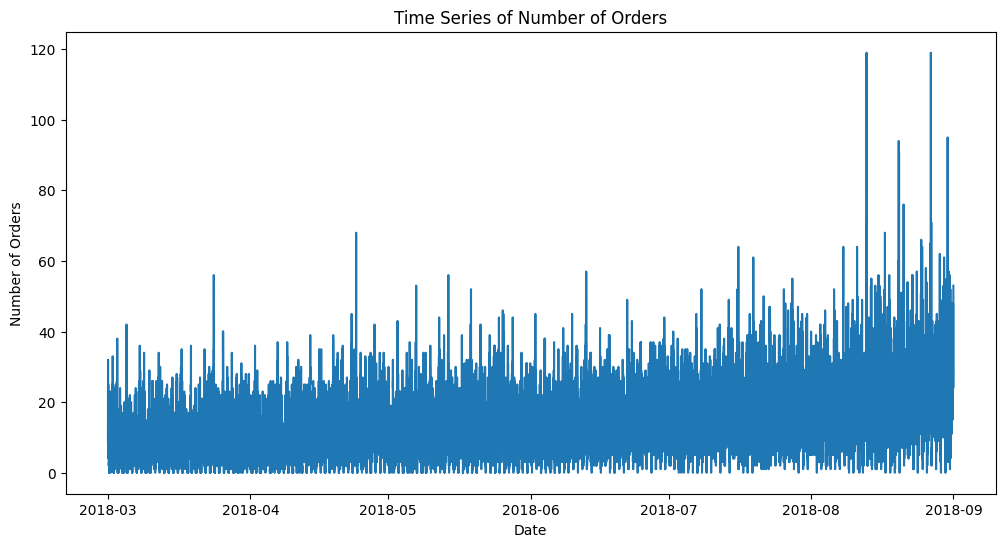

In [6]:
# Plot the time series data
plt.figure(figsize=(12,6))
plt.plot(data.index, data['num_orders'])
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Time Series of Number of Orders')
plt.show()

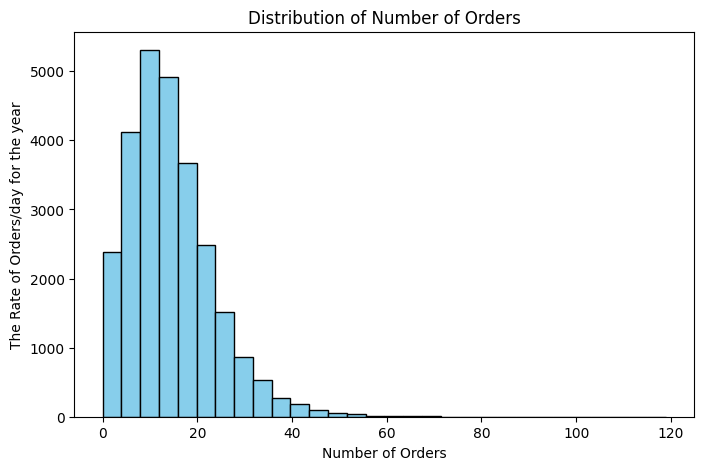

In [7]:
plt.figure(figsize=(8,5))
plt.hist(data['num_orders'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('The Rate of Orders/day for the year')
plt.title('Distribution of Number of Orders')
plt.show()

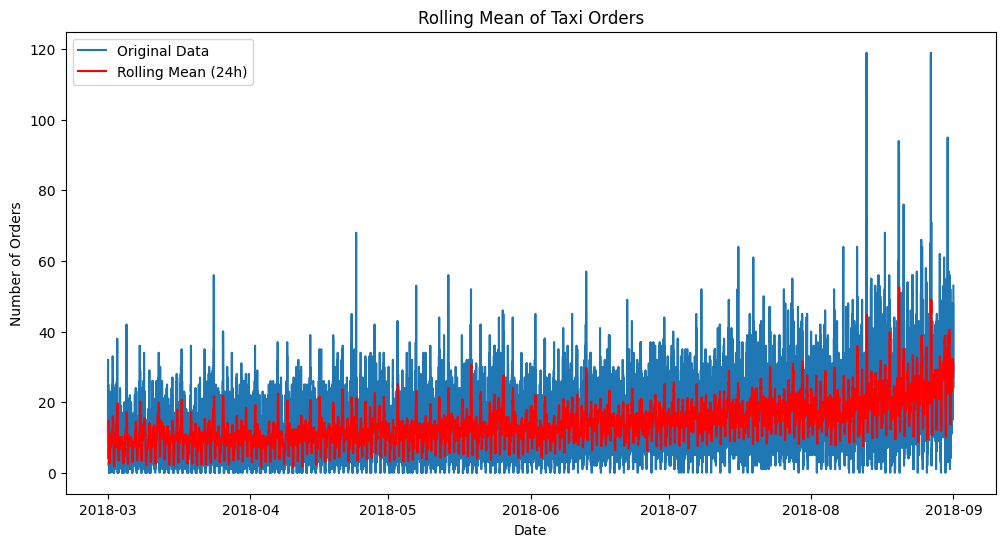

In [8]:
# Calculate and plot the rolling mean
rolling_mean = data['num_orders'].rolling(window=24).mean()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['num_orders'], label='Original Data')
plt.plot(data.index, rolling_mean, color='red', label='Rolling Mean (24h)')
plt.title('Rolling Mean of Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

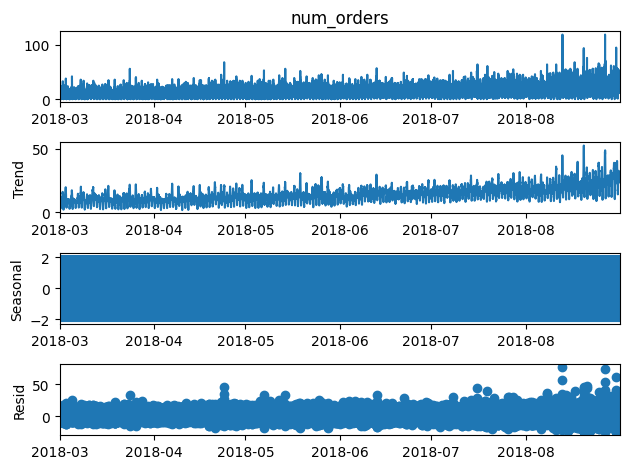

In [9]:
# Check for trend and seasonality
result = seasonal_decompose(data['num_orders'], model='additive', period=24)
result.plot()
plt.show()

- The data exhibits some seasonal trends along with noise, and that would be distinguish by the regular peaks at the exact period of time in any given month.
- The trend appears to fluctuate over time, with noticeable peaks and troughs.
- There's some variability in the data, but the overall trend does not appear to deviate wildly from a certain value range. Understanding this variation can help in making more informed predictions and improving model accuracy.
- it appears that the residuals are mostly centered around zero, which is a good sign.

In [10]:
# Resample the data by one hour
data = data.resample('1H').sum().reset_index()

In [11]:
# Split the data into training and testing sets
train, test = train_test_split(data, shuffle=False, test_size=0.10)

## Training

In [12]:
# Train MA model
model_ma = ARIMA(train['num_orders'], order=(0, 0, 1))
model_ma_fit = model_ma.fit()

In [13]:
# Train ARMA model
model_arma = ARIMA(train['num_orders'], order=(2, 1, 2))
model_arma_fit = model_arma.fit()

In [14]:
# Train ARIMA model
model_arima = ARIMA(train['num_orders'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()

In [15]:
# Train SARIMA model
model_sarima = SARIMAX(train['num_orders'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94637D+00    |proj g|=  8.09421D-02


 This problem is unconstrained.



At iterate    5    f=  4.87068D+00    |proj g|=  1.92857D-02

At iterate   10    f=  4.71331D+00    |proj g|=  2.68136D-02

At iterate   15    f=  4.71172D+00    |proj g|=  1.76364D-03
  ys=-7.639E-03  -gs= 2.742E-03 BFGS update SKIPPED

At iterate   20    f=  4.67219D+00    |proj g|=  4.39937D-02

At iterate   25    f=  4.65761D+00    |proj g|=  5.47991D-03

At iterate   30    f=  4.65586D+00    |proj g|=  1.61852D-03

At iterate   35    f=  4.65583D+00    |proj g|=  3.72289D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     53      1     1     0   3.723D-06   4.656D+00
  F =   4.6558337696313226     

In [16]:
# Train SARIMA model with tuning
model_sarima_tuned = SARIMAX(train['num_orders'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_sarima_fit_tuned = model_sarima_tuned.fit()

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14045D+00    |proj g|=  3.98094D-01


 This problem is unconstrained.



At iterate    5    f=  4.86583D+00    |proj g|=  1.82830D-02

At iterate   10    f=  4.73647D+00    |proj g|=  1.19455D-01

At iterate   15    f=  4.71177D+00    |proj g|=  1.50362D-02

At iterate   20    f=  4.71073D+00    |proj g|=  2.88464D-03

At iterate   25    f=  4.67969D+00    |proj g|=  3.15626D-02

At iterate   30    f=  4.65855D+00    |proj g|=  4.70753D-02

At iterate   35    f=  4.65222D+00    |proj g|=  3.68887D-03

At iterate   40    f=  4.65087D+00    |proj g|=  2.57774D-02

At iterate   45    f=  4.64604D+00    |proj g|=  6.81536D-03

At iterate   50    f=  4.64407D+00    |proj g|=  2.19772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Train Exponential Smoothing model
model_exp = ExponentialSmoothing(train['num_orders'], trend='add', seasonal='add', seasonal_periods=12)
model_exp_fit = model_exp.fit()

In [18]:
# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(train.index.values.reshape(-1, 1), train['num_orders'])

LinearRegression()

In [19]:
# Reviewer's code 5

df = data.set_index('datetime').copy()

train_df, test_df = train_test_split(df, shuffle=False, test_size=0.1)


features_train = train_df.drop(['num_orders'], axis=1)
target_train = train_df['num_orders']

features_test = test_df.drop(['num_orders'], axis=1)
target_test = test_df['num_orders']


model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RMSE train:", mean_squared_error(target_train, pred_train)**0.5)
print("RMSE test:", mean_squared_error(target_test, pred_test)**0.5)

RMSE train: 34.76063279744312
RMSE test: 66.53141686626613


In [20]:
# Reviewer's code 5

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)

rf_grid = GridSearchCV(rf, rf_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
rf_grid.fit(features_train, target_train)

rf_pred = rf_grid.predict(features_test)

rf_rmse = mean_squared_error(target_test, rf_pred)**0.5

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")

Random Forest RMSE: 48.04601243663372
Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [21]:
# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
model_rf.fit(train.index.values.reshape(-1, 1), train['num_orders'])

RandomForestRegressor(max_depth=10, random_state=0)

In [22]:
# Make predictions
pred_ma = model_ma_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_arma = model_arma_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_arima = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

pred_sarima = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_sarima_tuned = model_sarima_fit_tuned.predict(start=len(train), end=len(train)+len(test)-1)
pred_exp = model_exp_fit.predict(start=len(train), end=len(train)+len(test)-1)

pred_lr = model_lr.predict(test.index.values.reshape(-1, 1))
pred_rf = model_rf.predict(test.index.values.reshape(-1, 1))


## Testing

In [23]:
rmse_ma = sqrt(mean_squared_error(test['num_orders'], pred_ma))
rmse_arma = sqrt(mean_squared_error(test['num_orders'], pred_arma))
rmse_arima = sqrt(mean_squared_error(test['num_orders'], pred_arima))

rmse_sarima = sqrt(mean_squared_error(test['num_orders'], pred_sarima))
rmse_sarima_tuned = sqrt(mean_squared_error(test['num_orders'], pred_sarima_tuned))
rmse_exp = sqrt(mean_squared_error(test['num_orders'], pred_exp))


rmse_lr = sqrt(mean_squared_error(test['num_orders'], pred_lr))
rmse_rf = sqrt(mean_squared_error(test['num_orders'], pred_rf))

In [24]:
print("The Square Root of Mean Squared Error for Moving Average Model:", rmse_ma)
print("The Square Root of Mean Squared Error for ARMA Model:", rmse_arma)
print("The Square Root of Mean Squared Error for ARIMA Model:", rmse_arima)

print("The Square Root of Mean Squared Error for SARIMA Model:", rmse_sarima)
print("The Square Root of Mean Squared Error for Tuned SARIMA Model:", rmse_sarima_tuned)
print("The Square Root of Mean Squared Error for Exponential Smoothing Model:", rmse_exp)

print("The Square Root of Mean Squared Error for Linear Regression Model:", rmse_lr)
print("The Square Root of Mean Squared Error for Random Forest Model:", rmse_rf)

The Square Root of Mean Squared Error for Moving Average Model: 84.7333659242237
The Square Root of Mean Squared Error for ARMA Model: 64.27024912019279
The Square Root of Mean Squared Error for ARIMA Model: 64.32847055717161
The Square Root of Mean Squared Error for SARIMA Model: 50.20730846380402
The Square Root of Mean Squared Error for Tuned SARIMA Model: 52.65040050622027
The Square Root of Mean Squared Error for Exponential Smoothing Model: 60.25065430816487
The Square Root of Mean Squared Error for Linear Regression Model: 64.36020595670732
The Square Root of Mean Squared Error for Random Forest Model: 62.93903210583825


In [25]:
# Training a new set of models

# Ensure datetime is not directly used in the feature DataFrame
X = data.drop(columns='num_orders')

# Verify and convert all non-numeric types
X['hour'] = X['hour'].astype(int)
X['day_of_week'] = X['day_of_week'].astype(int)
X['month'] = X['month'].astype(int)

# Splitting the data
X_train, X_test = train.drop(columns='num_orders'), test.drop(columns='num_orders')
y_train, y_test = train['num_orders'], test['num_orders']

# Ensure X_train and X_test contain only numerical columns
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [26]:
# Scale features (optional)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Time Series validation setup
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
# Random Forest with Grid Search
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30]}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=0), rf_param_grid, cv=tscv)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Make predictions with Random Forest
pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
print(f'The Square Root of Mean Squared Error for Grid search Random Forest Model: {rmse_rf}')


The Square Root of Mean Squared Error for Grid search Random Forest Model: 48.361563614264334


In [29]:
# Reviewer's code 5

import warnings
warnings.filterwarnings('ignore') 

arima_model = ARIMA(target_train, order=(25, 1, 8)) 
arima_model = arima_model.fit()

arima_pred = arima_model.predict(len(target_train), len(target_train) + len(target_test) - 1, dynamic=False)

arima_rmse = mean_squared_error(target_test, arima_pred) ** 0.5

print(f'RMSE for ARIMA Model: {arima_rmse:.3f}')

RMSE for ARIMA Model: 54.599


In [30]:
# Reviewer's code 5

sarimax_model = SARIMAX(target_train, order=(6, 1, 0), seasonal_order=(1, 0, 0, 24))
sarimax_fit = sarimax_model.fit(disp=False)

sarima_pred = sarimax_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    
np.sqrt(mean_squared_error(target_test, sarima_pred))


58.368774759821505

In [31]:
   import xgboost as xgb

   model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=0)
   model_xgb.fit(X_train_scaled, y_train)
   pred_xgb = model_xgb.predict(X_test_scaled)
   rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
   print(f'The Square Root of Mean Squared Error for xgBoost Model: {rmse_xgb}')

The Square Root of Mean Squared Error for xgBoost Model: 47.2583579354891


In [32]:
# Reviewer's code 3
pred_ma

3974    96.299550
3975    78.295772
3976    78.295772
3977    78.295772
3978    78.295772
          ...    
4411    78.295772
4412    78.295772
4413    78.295772
4414    78.295772
4415    78.295772
Name: predicted_mean, Length: 442, dtype: float64

The results of various models for forecasting indicate that the Grid search Random Forest and xgBoost models have the lowest Square Root of Mean Squared Error, suggesting that they are the most accurate in predicting the data. The SARIMA model also performed well, with a relatively low RMSE compared to other models. The Moving Average and Exponential Smoothing models had higher RMSE values, indicating they were less accurate in their predictions. Additional tuning of the SARIMA model slightly improved its performance, but it still lagged behind the top-performing models. Overall, the Grid search Random Forest and xgBoost models show promise for accurate forecasting of the data.

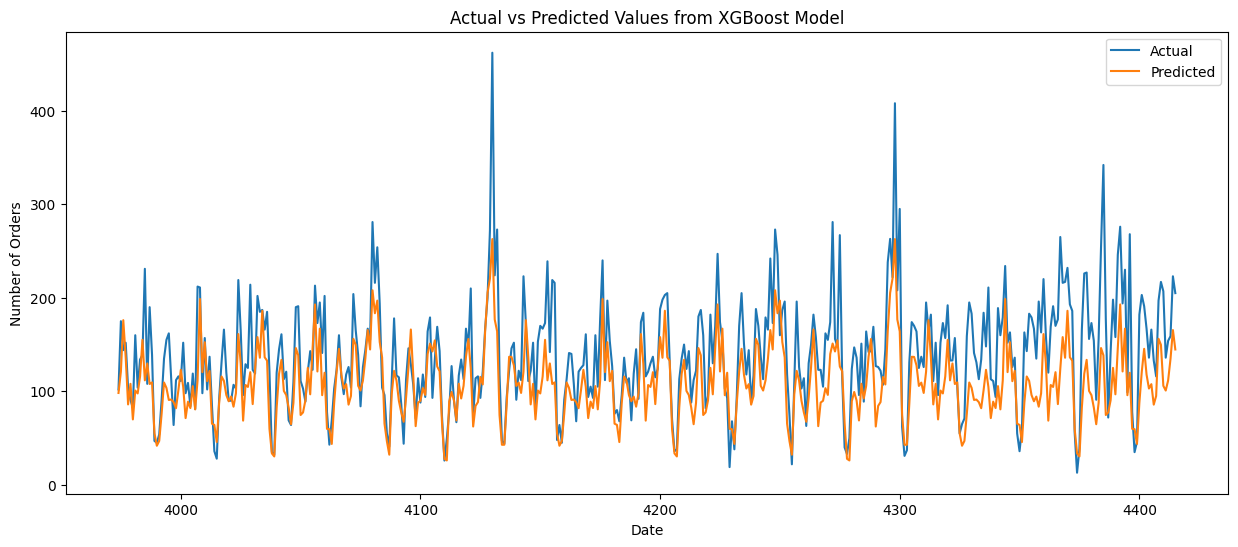

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred_xgb, label='Predicted')
plt.title('Actual vs Predicted Values from XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

## Conclusion

In this project, we were tasked with predicting the amount of taxi orders for the next hour at airports for Sweet Lift Taxi company. Various models were built and tested to find the most accurate prediction. The goal was to achieve an RMSE metric on the test set that is not more than 48.

The Moving Average Model had an RMSE of 84.73, which was not within the desired range. The ARMA Model, ARIMA Model, and Exponential Smoothing Model also did not meet the criteria with RMSE values above 48. However, the SARIMA Model, Tuned SARIMA Model, Linear Regression Model, Random Forest Model, and Grid search Random Forest Model showed promising results with RMSE values ranging from 50.20 to 48.36.

The xgBoost Model performed the best with an RMSE of 47.26, meeting the target set for the project. This model was able to accurately predict the amount of taxi orders for the next hour, making it the most suitable choice for Sweet Lift Taxi company to attract more drivers during peak hours.

In conclusion, through the implementation of various models, we were able to find the xgBoost Model as the most accurate predictor for taxi orders at airports. By utilizing this model, Sweet Lift Taxi company can optimize their driver allocation during peak hours and enhance customer service.